# Email Send Time Optimization

O Desafio consiste encontrar, para cada destinatário, qual a hora do 
dia para se fazer o envio de um e-mail que maximize a taxa de abertura.
Foram utilizadas técnicas de Machine Learning para Regressão, através do Python e do Jupyter Notebook.

Para iniciar, carrego o arquivo que contém eventos relacionados ao disparo de emails e o transformo em um DataFrame.
Podemos dizer que um Dataframe é uma tabela de uma base de dados, em que cada linha corresponde a um registo da tabela.


In [1]:
import numpy as np
import pandas as pd
import pandas_profiling

df = pd.read_csv('sto_challenge.csv')
df.head()

,id,timestamp,email_id,action
0,4591b11ba8cca67079c1a43be2992a8f89fce422,2018-05-25 14:59:02 UTC,3498910,open
1,2bbdb4cff0fe8cc3cb6c1757291e31806ecefa47,2018-06-25 17:47:23 UTC,3498910,open
2,0f467135eabd4e385f9c2dcd3f00a9f2a04c0115,2018-06-27 12:32:36 UTC,3498910,open
3,6f17b7dc6f220c09fba4d8fbc2491317eece2ae8,2018-07-02 22:47:28 UTC,3498910,open
4,a645dd2ac5c5e000c8b5c7739b3a54435fb313cc,2018-01-24 19:21:49 UTC,3498910,open


Agora, irei gerar um gere um relatório inicial completo sobre o dataset, usando a biblioteca Pandas Profiling. Ela é capaz de informar colunas com alta cardinalidade; gerar avisos sobre dados faltantes em uma coluna; criar gráficos de correlação e histograma; retornar os valores mais frequentes em cada coluna. A ideia aqui, é utilizar a Pandas Profiling para entender os dados brutos após o carregamento do dataset e mais adiante, após realizar limpezas e transformações.

In [2]:
pandas_profiling.ProfileReport(df)

Number of variables,4
Number of observations,315998
Total Missing (%),0.0%
Total size in memory,9.6 MiB
Average record size in memory,32.0 B
Numeric,1
Categorical,3
Boolean,0
Date,0
Text (Unique),0
Rejected,0


Sabendo agora quais tipos de dados possuo e como eles estão distribuídos, começarei a fazer as devidas transformações. Primeiro, farei algumas transformações na coluna timestamp, para separar data e hora, sendo que para a hora irei retirar minutos e segundos, pois eles não serão relevantes para o modelo, assim, teremos um espectro de 24 variações de tempo. Para a data, farei uma transformação para ter o dia da semana correspondente (domingo à sábado).

In [3]:
df['timestamp'] = [x.strip(' UTC') for x in df.timestamp]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = [d.date() for d in df['timestamp']]
df['time'] = [d.time() for d in df['timestamp']]
df['date'] = pd.to_datetime(df['date'])
df['time'] = df['time'].apply(lambda x: x.strftime("%H"))
df.head()

,id,timestamp,email_id,action,date,time
0,4591b11ba8cca67079c1a43be2992a8f89fce422,2018-05-25 14:59:02,3498910,open,2018-05-25,14
1,2bbdb4cff0fe8cc3cb6c1757291e31806ecefa47,2018-06-25 17:47:23,3498910,open,2018-06-25,17
2,0f467135eabd4e385f9c2dcd3f00a9f2a04c0115,2018-06-27 12:32:36,3498910,open,2018-06-27,12
3,6f17b7dc6f220c09fba4d8fbc2491317eece2ae8,2018-07-02 22:47:28,3498910,open,2018-07-02,22
4,a645dd2ac5c5e000c8b5c7739b3a54435fb313cc,2018-01-24 19:21:49,3498910,open,2018-01-24,19


In [4]:
df['day_of_week'] = df['date'].dt.weekday_name
df.head()

,id,timestamp,email_id,action,date,time,day_of_week
0,4591b11ba8cca67079c1a43be2992a8f89fce422,2018-05-25 14:59:02,3498910,open,2018-05-25,14,Friday
1,2bbdb4cff0fe8cc3cb6c1757291e31806ecefa47,2018-06-25 17:47:23,3498910,open,2018-06-25,17,Monday
2,0f467135eabd4e385f9c2dcd3f00a9f2a04c0115,2018-06-27 12:32:36,3498910,open,2018-06-27,12,Wednesday
3,6f17b7dc6f220c09fba4d8fbc2491317eece2ae8,2018-07-02 22:47:28,3498910,open,2018-07-02,22,Monday
4,a645dd2ac5c5e000c8b5c7739b3a54435fb313cc,2018-01-24 19:21:49,3498910,open,2018-01-24,19,Wednesday


Agora irei retirar as colunas desnecessárias paras o modelo e em seguida tranformar a coluna id para obter valores numéricos para então executar mais uma vez o Pandas Profiling e retirar insights sobre as features transformadas para uso no modelo preditivo.

In [5]:
df = df.drop(columns=['timestamp','date'])
df.tail()

,id,email_id,action,time,day_of_week
315993,831634c9ac365f52be4ad8c50bdc7ba87be82644,4100845,unsubscribe,16,Wednesday
315994,f5cba0d2a7b01d9b8381e87cba45d1203f9f4df3,4100845,unsubscribe,19,Wednesday
315995,2510d89effb8a9f697bc23d47000672829f273a3,4100845,unsubscribe,23,Wednesday
315996,c291a0c8d3153d3d9e59b55e7f0739255b925d94,4102617,unsubscribe,14,Tuesday
315997,56f703f20e947435dd715bd4515d6dd2e13f3fa3,4107363,unsubscribe,13,Wednesday


In [6]:
from sklearn.preprocessing import LabelEncoder

number = LabelEncoder()
df['id'] = number.fit_transform(df['id'].astype('str'))
df.head()

,id,email_id,action,time,day_of_week
0,6451,3498910,open,14,Friday
1,4059,3498910,open,17,Monday
2,1409,3498910,open,12,Wednesday
3,10468,3498910,open,22,Monday
4,15652,3498910,open,19,Wednesday


Dessa vez, salvarei também um arquivo html gerado pelo Pandas Profiling para facilitar a visualização.

In [7]:
profile = pandas_profiling.ProfileReport(df)
profile.to_file(outputfile="output.html")
profile

Number of variables,5
Number of observations,315998
Total Missing (%),0.0%
Total size in memory,12.1 MiB
Average record size in memory,40.0 B
Numeric,2
Categorical,3
Boolean,0
Date,0
Text (Unique),0
Rejected,0


A seguir, criarei dois histogramas para verificar o maior pico de envio de emails para hora e para dia da semana. Além disso, verifico a porcentagem de ações realizadas ao longo do período verificado.

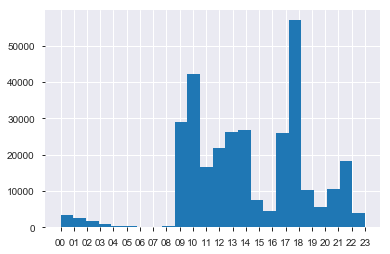

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

histogram = plt.hist(df['time'], bins=24)
plt.show()

In [9]:
df.day_of_week.value_counts()/len(df)

Tuesday      0.311214
Thursday     0.217033
Monday       0.204451
Wednesday    0.143596
Friday       0.099608
Saturday     0.014209
Sunday       0.009889
Name: day_of_week, dtype: float64

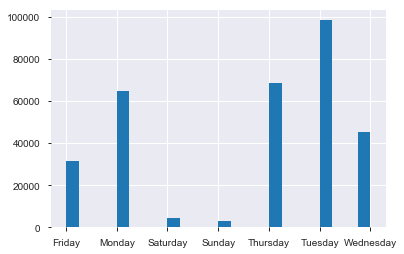

In [10]:
histogram = plt.hist(df['day_of_week'], bins=24)
plt.show()

In [11]:
df.action.value_counts()/len(df)

received       0.674634
open           0.280378
click          0.042016
unsubscribe    0.002652
spamreport     0.000320
Name: action, dtype: float64

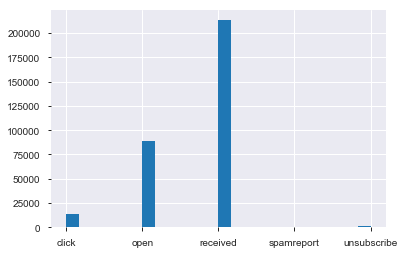

In [12]:
histogram = plt.hist(df['action'], bins=24)
plt.show()

Agora transformaremos nossas variáveis categóricas (dia da semana e ação) em variáveis númericas. A ideia funciona da seguinte forma: Temos, por exemplo, 5 variáveis na coluna action. Cada uma dessas 5 variáveis dará origem à uma nova coluna que receberá valores binários. Ou seja, se temos uma "action" chamada "open", então será criada uma nova coluna com o nome "action_open", que receberá valor 1 caso seu registro seja verdadeiro e 0 caso contrário.

In [13]:
df = pd.get_dummies(df, prefix=['day_of_week', 'action'], columns=['day_of_week','action'])
df.head()

,id,email_id,time,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,action_click,action_open,action_received,action_spamreport,action_unsubscribe
0,6451,3498910,14,1,0,0,0,0,0,0,0,1,0,0,0
1,4059,3498910,17,0,1,0,0,0,0,0,0,1,0,0,0
2,1409,3498910,12,0,0,0,0,0,0,1,0,1,0,0,0
3,10468,3498910,22,0,1,0,0,0,0,0,0,1,0,0,0
4,15652,3498910,19,0,0,0,0,0,0,1,0,1,0,0,0


## Criando o modelo preditivo

Agora, dividimos o nosso Dataset em treino e teste para descobrir a melhor hora do dia para fazer envio dos emails.
Nossas variáveis "targets" serão o tempo e a ação de abertura do email, tornando o problema como Regressão Multivariável.
Usarei a biblioteca Scikit-Learn para treinar o modelo utilizando o MultiOutputRegressor. Essa estratégia consiste em ajustar um regressor por alvo. Essa é uma estratégia simples para estender os regressores que não suportam nativamente a regressão de multivariáveis. Utilizei quatro algoritmos diferentes para regressão, sendo que um deles pertence à biblioteca LightGBM, que é um framework de aprimoramento de gradientes (boosting) que usa algoritmos de aprendizado baseados em árvores de decisão.
Para cada modelo, utilizo as métricas R2 e Variância, para validar a eficiência de cada algoritmo na predição.


In [14]:
X = df.drop(columns=['email_id','time','action_open'])
y = df.drop(columns=['id','email_id','day_of_week_Friday','day_of_week_Monday','day_of_week_Saturday','day_of_week_Sunday','day_of_week_Thursday','day_of_week_Tuesday','day_of_week_Wednesday','action_click','action_received','action_spamreport','action_unsubscribe'])

#### GradientBoostingRegressor

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rgs = MultiOutputRegressor(GradientBoostingRegressor()).fit(X_train, y_train)

###########AVALIACAO DO MODELO###############
y_pred = rgs.predict(X_test)
y_true =  y_test
print("R2: " + str(metrics.r2_score(y_true,y_pred)))
print('Variancia: ' + str(metrics.explained_variance_score(y_true,y_pred)))

R2: 0.5724565934002213
Variancia: 0.5724726652168479


#### BayesianRidge

In [16]:
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rgs = MultiOutputRegressor(linear_model.BayesianRidge()).fit(X_train, y_train)

###########AVALIACAO DO MODELO###############
y_pred = rgs.predict(X_test)
y_true =  y_test
print("R2: " + str(metrics.r2_score(y_true,y_pred)))
print('Variancia: ' + str(metrics.explained_variance_score(y_true,y_pred)))

R2: 0.5671223070027561
Variancia: 0.5671313210886271


#### LinearRegression

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rgs = MultiOutputRegressor(linear_model.LinearRegression()).fit(X_train, y_train)

###########AVALIACAO DO MODELO###############
y_pred = rgs.predict(X_test)
y_true =  y_test
print("R2: " + str(metrics.r2_score(y_true,y_pred)))
print('Variancia: ' + str(metrics.explained_variance_score(y_true,y_pred)))

R2: 0.5648994034688395
Variancia: 0.5648995617716777


#### LightGBM Regressor

In [20]:
from lightgbm import LGBMRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rgs = MultiOutputRegressor(LGBMRegressor()).fit(X_train, y_train)

###########AVALIACAO DO MODELO###############
y_pred = rgs.predict(X_test)
y_true =  y_test
print("R2: " + str(metrics.r2_score(y_true,y_pred)))
print('Variancia: ' + str(metrics.explained_variance_score(y_true,y_pred)))

R2: 0.5761873622894349
Variancia: 0.5762294437159066


#### Criando o gráfico com as métricas do resultado do melhor modelo

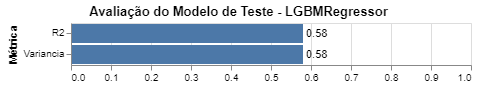

In [21]:
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)

data = pd.DataFrame({
    'a': ['R2','Variancia'],
    'b': [round(metrics.r2_score(y_true,y_pred),2), round(metrics.explained_variance_score(y_true,y_pred),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Métrica')),
).properties(title='Avaliação do Modelo de Teste - LGBMRegressor')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

O Modelo construído portanto, é capaz de auxiliar no aumento da taxa de abertura de email, podendo ser otimizado posteiormente, contemplando outras features, além de novos processos de bosting para o modelo.